# **Topic Modeling and Sentiment Classification on IMDB Movie Reviews**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **1. Install Required Packages**

In [2]:
!pip install "tweet-preprocessor==0.5.0"
!pip install "seaborn==0.11.2"
!pip install "networkx==2.6.3"
!pip install "transformers==4.18.0"
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-py3-none-any.whl size=7961 sha256=c1af1ed4bd90cb94e0d4a7ad4c9e7bc527b6667a7624cdea5b31a853f4e7a65f
  Stored in directory: /root/.cache/pip/wheels/af/14/89/4e427492edc4f92e8f33867aedddd879e988459b709f46c509
Successfully built tweet-preprocessor
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 35.3 MB/s 
     |████████████████████████████████| 6.6 MB 59.0 MB/s 
     |████████████████████████████████| 880 kB 56.8 MB/s 
     |████████████████████████████████| 163 kB 54.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## **2. Import Certain Libraries**

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import string
import preprocessor as p
import warnings

import nltk
from nltk import word_tokenize, FreqDist, bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer
from transformers import TFBertModel
from tensorflow.keras.models import model_from_json

plt.style.use("seaborn-darkgrid")
warnings.filterwarnings('ignore')
%matplotlib inline
%config IPCompleter.greedy=True

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

## **3. Load Dataset**

In [5]:
IMDB_df = pd.read_csv('/content/drive/MyDrive/IMDB Sentiment Analysis/IMDB Dataset.csv')
print(IMDB_df.shape)
IMDB_df.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
#Summary of the dataset
IMDB_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
# dropping ALL duplicte values
IMDB_df.drop_duplicates(subset ="review", keep = "first", inplace = True)
IMDB_df.to_csv("/content/drive/MyDrive/IMDB Sentiment Analysis/IMDB Dataset.csv", index=False)
IMDB_df = pd.read_csv('/content/drive/MyDrive/IMDB Sentiment Analysis/IMDB Dataset.csv')

new_IMDB_df = IMDB_df
print(new_IMDB_df.shape)
new_IMDB_df.head()

(49582, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## **4. Preprocessing of IMDB Reviews**

In [8]:
# converting reviews into lower case
def comment_lower(comment):
    return comment.lower()

# removing website links (parts starting with http) from reviews
def remove_links(comment):
    comment = re.sub("https?:\/\/\S+", "", comment)
    return comment

# removing breaks from reviews
def remove_breaks(comment):
    comment = re.sub("<br />", "", comment)
    return comment

# removing numbers
def remove_numbers(comment):
    comment = re.sub(r'\d+', '', str(comment))
    return comment

# removing punctuation from reviews
def remove_punctuation(comment):
    translator = str.maketrans('', '', string.punctuation)
    return comment.translate(translator)

# tokenization of reviews
def tokenize(comment):
    comment = word_tokenize(comment)
    return comment

# removing stopwords from reviews 
stop_words = set(stopwords.words('english'))
def remove_stopwords(comment):
    comment = [i for i in comment if not i in stop_words]
    return comment

# lemmatization of reviews
lemmatizer = WordNetLemmatizer()
def lemmatize(comment):
    comment = [lemmatizer.lemmatize(token) for token in comment]
    return comment

def preprocessing(comment):
    comment = comment_lower(comment)
    comment = remove_links(comment)
    comment = remove_breaks(comment)
    comment = remove_numbers(comment)
    comment = remove_punctuation(comment)
    comment = tokenize(comment)
    comment = remove_stopwords(comment)
    comment = lemmatize(comment)
    comment = ' '.join(comment)
    return comment

In [9]:
clean_reviews = []
for comment in new_IMDB_df['review']:
    initial_pp_review = p.clean(str(comment))
    preprocessed_review = preprocessing(initial_pp_review)
    clean_reviews.append(preprocessed_review)

new_IMDB_df['clean_review'] = clean_reviews
new_IMDB_df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [10]:
# saving the Preprocessed Reviews into Original Dataset
df = pd.read_csv('/content/drive/MyDrive/IMDB Sentiment Analysis/IMDB Dataset.csv')
df["clean_review"] = new_IMDB_df['clean_review']
df.to_csv("/content/drive/MyDrive/IMDB Sentiment Analysis/IMDB Dataset.csv", index=False)
new_IMDB_df = pd.read_csv('/content/drive/MyDrive/IMDB Sentiment Analysis/IMDB Dataset.csv')

## **5. Popular Token Identification**

In [11]:
tokens = []
for comment in new_IMDB_df["clean_review"]:
    for token in word_tokenize(comment):
        tokens.append(token)

In [12]:
print(tokens[:20])

['one', 'reviewer', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly', 'happened', 'methe', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scene', 'violence']


In [13]:
FreqDist(tokens).most_common()[:25]

[('movie', 98278),
 ('film', 89190),
 ('one', 52277),
 ('like', 39456),
 ('time', 29150),
 ('good', 28413),
 ('character', 27346),
 ('get', 24242),
 ('even', 24084),
 ('story', 24072),
 ('would', 23803),
 ('make', 23409),
 ('see', 23286),
 ('really', 22730),
 ('scene', 20561),
 ('much', 18733),
 ('well', 18486),
 ('people', 17816),
 ('great', 17680),
 ('bad', 17492),
 ('also', 17368),
 ('first', 16696),
 ('show', 16658),
 ('dont', 16449),
 ('way', 16398)]

In [14]:
fdist = FreqDist(tokens).most_common()[:25]
fdist_dict = dict(fdist)
fdist_dict_sorted = sorted(fdist_dict.items(), key=lambda kv: kv[1], reverse=True)
token, token_counts = list(zip(*fdist_dict_sorted))
token_str = list(map(lambda x: ''.join(x), token))
token_arr = np.array(token_str)
token_counts_arr = np.array(token_counts)

Text(0, 0.5, 'Count')

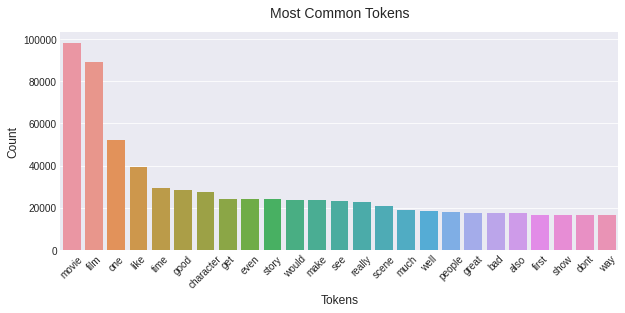

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(token_arr, token_counts_arr)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title("Most Common Tokens", fontsize=14, pad=15)
ax.set_xlabel("Tokens", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

### **5.1. Wordcloud Visualization from Positive reviews**

In [16]:
Pos_IMDB_df = new_IMDB_df[new_IMDB_df['sentiment'] == 'positive']
Pos_IMDB_df.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...
5,"Probably my all-time favorite movie, a story o...",positive,probably alltime favorite movie story selfless...


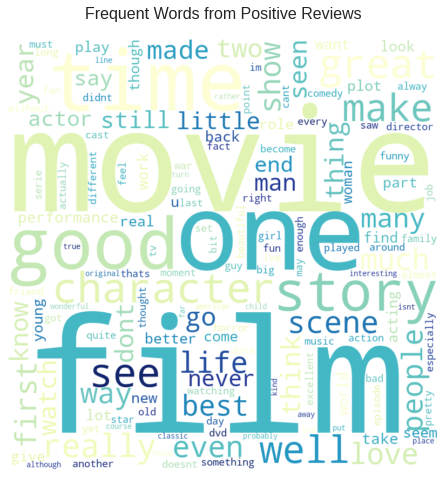

In [17]:
pos_words = ' '.join(str(review) for review in Pos_IMDB_df['clean_review'])
wordcloud = WordCloud(width = 800, height = 800,
                      colormap = 'YlGnBu',
                      background_color = 'white',
                      min_font_size = 12,
                      max_words = 150,
                      stopwords = STOPWORDS,
                      collocations = False).generate(pos_words) 
                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words from Positive Reviews", fontsize=16, pad=20)
plt.show() 

### **5.2. Wordcloud Visualization from Negative reviews**

In [18]:
Neg_IMDB_df = new_IMDB_df[new_IMDB_df['sentiment'] == 'negative']
Neg_IMDB_df.head()

,review,sentiment,clean_review
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
7,"This show was an amazing, fresh & innovative i...",negative,show amazing fresh innovative idea first aired...
8,Encouraged by the positive comments about this...,negative,encouraged positive comment film looking forwa...
10,Phil the Alien is one of those quirky films wh...,negative,phil alien one quirky film humour based around...
11,I saw this movie when I was about 12 when it c...,negative,saw movie came recall scariest scene big bird ...


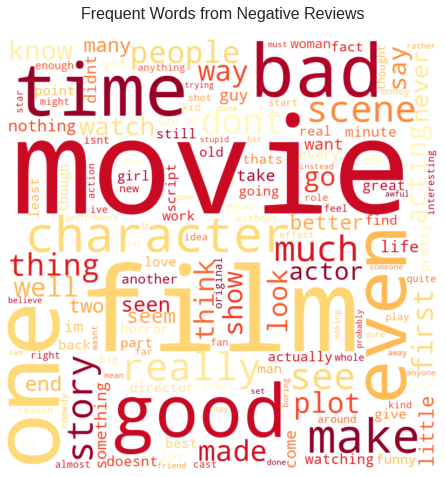

In [19]:
neg_words = ' '.join(str(review) for review in Neg_IMDB_df['clean_review'])
wordcloud = WordCloud(width = 800, height = 800,
                      colormap = 'YlOrRd',
                      background_color = 'white',
                      min_font_size = 12,
                      max_words = 150,
                      stopwords = STOPWORDS,
                      collocations = False).generate(neg_words) 
                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Frequent Words from Negative Reviews", fontsize=16, pad=20)
plt.show() 

## **6. n-gram Analysis**

In [20]:
comment_list = []
for comment in new_IMDB_df["clean_review"]:
    tokens = []
    for token in word_tokenize(comment):
        tokens.append(token)
    comment_list.append(tokens)

### **6.1. Bigram Analysis**

In [21]:
bigrams_list = []
for comment_tokens in comment_list:
    bigrams_list.extend(list(bigrams(comment_tokens)))

In [22]:
bigrams_freq = Counter(bigrams_list)
bigrams_freq.most_common(25)

[(('look', 'like'), 2855),
 (('ever', 'seen'), 2522),
 (('special', 'effect'), 2190),
 (('ive', 'seen'), 2116),
 (('dont', 'know'), 2036),
 (('main', 'character'), 1857),
 (('even', 'though'), 1850),
 (('one', 'best'), 1834),
 (('year', 'old'), 1731),
 (('movie', 'like'), 1702),
 (('movie', 'ever'), 1535),
 (('horror', 'movie'), 1485),
 (('see', 'movie'), 1481),
 (('good', 'movie'), 1452),
 (('waste', 'time'), 1425),
 (('much', 'better'), 1412),
 (('horror', 'film'), 1364),
 (('watch', 'movie'), 1348),
 (('first', 'time'), 1322),
 (('im', 'sure'), 1314),
 (('bad', 'movie'), 1310),
 (('ive', 'ever'), 1291),
 (('make', 'movie'), 1273),
 (('new', 'york'), 1271),
 (('film', 'like'), 1244)]

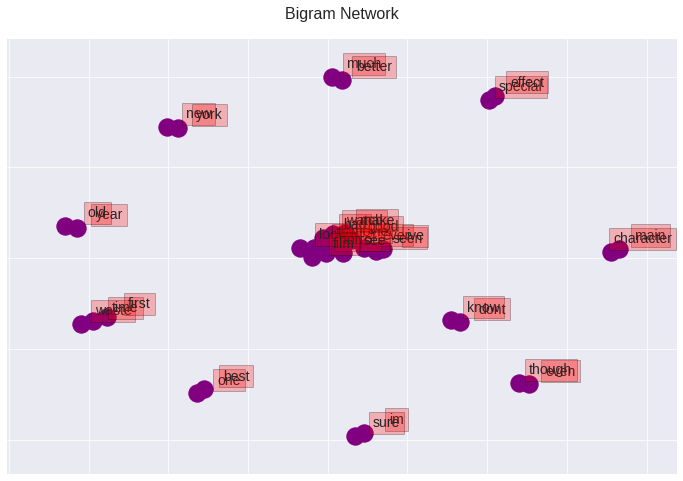

In [23]:
G = nx.Graph()
for b, freq in bigrams_freq.most_common(25):
    G.add_edge(b[0], b[1], weight=freq)

plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)

nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color="grey",
                 node_color="purple",
                 with_labels=False)

# create offset labels
for key, value in pos.items():
    x, y = value[0] + 0.1, value[1] + 0.05
    plt.text(x, y, s=key,
             bbox=dict(facecolor="red", alpha=0.25),
             horizontalalignment="center", fontsize=14)
    
plt.title("Bigram Network", fontsize=16, pad=20)
plt.show()

### **6.2. Trigram Analysis**

In [24]:
trigrams_list = []
for comment_tokens in comment_list:
    trigrams_list.extend(list(trigrams(comment_tokens)))

In [25]:
trigrams_freq = Counter(trigrams_list)
trigrams_freq.most_common(25)

[(('ive', 'ever', 'seen'), 980),
 (('worst', 'movie', 'ever'), 564),
 (('movie', 'ever', 'seen'), 511),
 (('movie', 'ive', 'ever'), 358),
 (('movie', 'ever', 'made'), 338),
 (('one', 'worst', 'movie'), 324),
 (('dont', 'waste', 'time'), 321),
 (('movie', 'ive', 'seen'), 293),
 (('film', 'ever', 'made'), 291),
 (('worst', 'film', 'ever'), 269),
 (('new', 'york', 'city'), 262),
 (('film', 'ive', 'seen'), 256),
 (('film', 'ever', 'seen'), 248),
 (('dont', 'get', 'wrong'), 238),
 (('worst', 'movie', 'ive'), 233),
 (('world', 'war', 'ii'), 206),
 (('film', 'ive', 'ever'), 191),
 (('one', 'worst', 'film'), 178),
 (('waste', 'time', 'money'), 171),
 (('one', 'best', 'movie'), 170),
 (('based', 'true', 'story'), 163),
 (('one', 'best', 'film'), 160),
 (('seen', 'long', 'time'), 155),
 (('first', 'time', 'saw'), 149),
 (('ive', 'never', 'seen'), 144)]

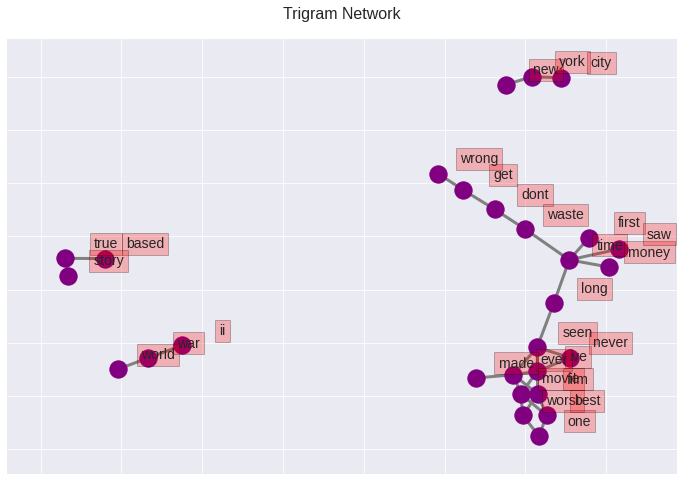

In [26]:
G = nx.Graph()
for b, freq in trigrams_freq.most_common(25):
    G.add_edge(b[0], b[1], weight=freq)
    G.add_edge(b[1], b[2], weight=freq)

plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)

nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color="grey",
                 node_color="purple",
                 with_labels=False)

# create offset labels
for key, value in pos.items():
    x, y = value[0] + 0.1, value[1] + 0.05
    plt.text(x, y, s=key,
             bbox=dict(facecolor="red", alpha=0.25),
             horizontalalignment="center", fontsize=14)

plt.title("Trigram Network", fontsize=16, pad=20)    
plt.show()

## **7. LDA Topic Modeling**

### **7.1. Data Preperation**

In [27]:
comments_for_lda = [" ".join(words) for words in comment_list]
comments_for_lda[:3]

['one reviewer mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focus mainly emerald city eerimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard wholl sold nickel inmate wholl kill order get away well mannered middle class inmate turned prison bitc

### **7.2. Vectorization**

In [28]:
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(comments_for_lda)
tf_feature_names = tf_vectorizer.get_feature_names()

### **7.3. Model Training**

In [29]:
k = 10
lda_topic_model = LatentDirichletAllocation(n_components=k, random_state=0).fit(tf)
doc_topics = lda_topic_model.transform(tf)

In [30]:
no_top_words = 10
for i, topic in enumerate(lda_topic_model.components_):
    print(i, [tf_feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

0 ['film', 'movie', 'one', 'like', 'get', 'bad', 'scene', 'even', 'make', 'good']
1 ['show', 'one', 'get', 'comedy', 'even', 'love', 'film', 'also', 'two', 'funny']
2 ['film', 'one', 'character', 'movie', 'time', 'scene', 'like', 'performance', 'make', 'best']
3 ['movie', 'like', 'one', 'good', 'film', 'really', 'time', 'would', 'see', 'dont']
4 ['film', 'movie', 'like', 'one', 'great', 'character', 'story', 'original', 'animation', 'also']
5 ['trek', 'mummy', 'spock', 'kirk', 'enterprise', 'critter', 'ant', 'shatner', 'mccoy', 'star']
6 ['film', 'one', 'also', 'performance', 'role', 'character', 'scene', 'story', 'man', 'play']
7 ['kid', 'film', 'movie', 'allen', 'one', 'family', 'che', 'woody', 'like', 'see']
8 ['one', 'show', 'get', 'time', 'like', 'film', 'year', 'also', 'good', 'back']
9 ['film', 'story', 'one', 'life', 'character', 'people', 'time', 'war', 'world', 'would']


### **7.4. Topic Allocation**

In [31]:
doc_topic_index = [doc_topics[i].argmax() for i in range(doc_topics.shape[0])]
doc_topic_index[:5]

[9, 2, 2, 0, 2]

In [32]:
new_IMDB_df["topic"] = doc_topic_index  # Use the result to add a new column "topic".
new_IMDB_df.head()

,review,sentiment,clean_review,topic
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,9
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,2
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,2
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,2


### **7.5. Visualization of Topic Popularity**

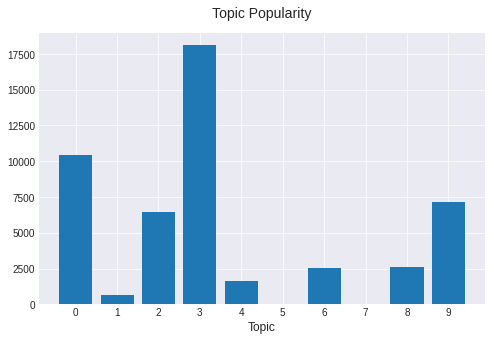

In [33]:
topic_counts = new_IMDB_df["topic"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(topic_counts.index, topic_counts)
plt.title("Topic Popularity", fontsize=14, pad=15)
plt.xlabel("Topic", fontsize = 12)
plt.xticks(range(k))
plt.show()

## **8. Sentiment Classification**

### **8.1. Prepare Final Data**

In [34]:
cols = ['Sentiment', 'Review']
final_IMDB_df = pd.DataFrame(columns=cols, index=range(len(new_IMDB_df.index)))
final_IMDB_df["Sentiment"] = ""

for i in range(0,len(new_IMDB_df.index)):
    if new_IMDB_df['sentiment'].iloc[i] == 'positive':
        final_IMDB_df["Sentiment"].iloc[i] = 1
    else:
        final_IMDB_df["Sentiment"].iloc[i] = 0

final_IMDB_df["Sentiment"] = final_IMDB_df["Sentiment"].astype("float32")
final_IMDB_df["Review"] = new_IMDB_df['clean_review']
final_IMDB_df.to_csv("/content/drive/MyDrive/IMDB Sentiment Analysis/IMDB Final Data.csv", index=False)
final_IMDB_df.head()

,Sentiment,Review
0,1.0,one reviewer mentioned watching oz episode you...
1,1.0,wonderful little production filming technique ...
2,1.0,thought wonderful way spend time hot summer we...
3,0.0,basically there family little boy jake think t...
4,1.0,petter matteis love time money visually stunni...


In [35]:
final_IMDB_df['Sentiment'].value_counts()

1.0    24884
0.0    24698
Name: Sentiment, dtype: int64

### **8.2. Generate Encoded Training and Validation Data**

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [37]:
token = tokenizer.encode_plus(
    final_IMDB_df['Review'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

In [38]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,  1141, 12827,  3025,  2903, 24919,  2004,  1128,  2339,
        14111,  1268,  2839,  2171,  1899,  4638,  1148,  1645,  4168,
        24919, 28024,  8362,  2087,  2836,  7520,  2741,  4289,  1383,
         1268,  1937,  1301,  3496,  1437,  7859, 21898,   189,  4060,
         2386,  1437,  3373,  9592,  7328,  3850,  2673,  4289, 16883,
         5263,  1329,  1937,  2875,  1270, 24919,  8002,  1549,   184,
         1116, 11022,  4177,  2699,  1352,  8228,  3150, 17103,  2817,
         2871, 23970,  1331,   174,  9866, 15595,  2237,  3315,  2765,
         2525,  1524,  1339, 23120,  1116,  9909,  1344, 12932,  9712,
         1331,  1313,  1242,  3113,  5443,   182,  1361, 24891, 21813,
         1777,  2495, 20064, 22572, 12937,  1811,  1122, 19457,  1179,
          178,  4889,  1324,  1167,  7301,   188, 10182, 13327,  1473,
         5698,  1202,  1181,  4873,  6705,   188, 24905,  3311,  1309,
         1677,  1283,  1182, 

In [39]:
X_input_ids = np.zeros((len(final_IMDB_df), 256))
X_attn_masks = np.zeros((len(final_IMDB_df), 256))

In [40]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(final_IMDB_df['Review'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [41]:
X_input_ids, X_attn_masks = generate_training_data(final_IMDB_df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [42]:
labels = final_IMDB_df['Sentiment'].values
print(labels.shape)
labels

(49582,)


array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [43]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [44]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [45]:
dataset = dataset.map(SentimentDatasetMapFunction)
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.float32, name=None))>

#### **8.2.1. Train-Validation Split**

In [46]:
train_prop = 0.8
train_size = int((len(final_IMDB_df))*train_prop)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

print ("Size of Training Data - ", train_size)
print ("Size of Validation Data - ", (len(final_IMDB_df)-train_size))

Size of Training Data -  39665
Size of Validation Data -  9917


In [47]:
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

### **8.3. Implement BERT Model**

In [48]:
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [49]:
# Model Input Layer
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

# BERT Embedding Layer
bert_embds = bert_model.bert(input_ids, attention_mask=attn_masks)[1]

# Neural Network Layer
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')(intermediate_layer)

bert_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

### **8.4. Train Model**

In [50]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)

METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

bert_model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=METRICS)

In [51]:
hist = bert_model.fit(train_dataset, validation_data=val_dataset, epochs=2)

Epoch 1/2
1240/1240 [==============================] - 2240s 2s/step - loss: 0.3189 - accuracy: 0.8604 - precision: 0.8596 - recall: 0.8625 - val_loss: 0.2499 - val_accuracy: 0.9006 - val_precision: 0.9122 - val_recall: 0.8880
Epoch 2/2
1240/1240 [==============================] - 2221s 2s/step - loss: 0.2091 - accuracy: 0.9168 - precision: 0.9153 - recall: 0.9191 - val_loss: 0.2494 - val_accuracy: 0.9026 - val_precision: 0.9060 - val_recall: 0.8999


In [52]:
bert_model.evaluate(val_dataset)

310/310 [==============================] - 177s 568ms/step - loss: 0.2494 - accuracy: 0.9026 - precision: 0.9060 - recall: 0.8999


[0.2494109570980072, 0.9025915265083313, 0.906029462814331, 0.8998597860336304]

## **9. Sentiment Prediction**

### **9.1. Sentiment Prediction on Validation Data**

In [53]:
y_predicted = bert_model.predict(val_dataset)
y_predicted = y_predicted.flatten()
y_predicted

310/310 [==============================] - 178s 565ms/step


array([0.8557129 , 0.894769  , 0.00354701, ..., 0.5166714 , 0.02715977,
       0.0035089 ], dtype=float32)

In [54]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, ..., 1, 0, 0])

In [55]:
y_test = np.concatenate([y for x, y in val_dataset], axis=0)
y_test

array([1., 1., 0., ..., 0., 0., 0.], dtype=float32)

### **9.2. Model Performance Analysis**

Text(0.5, 1.0, 'Confusion Matrix')

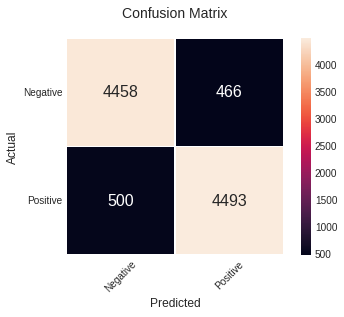

In [56]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_predicted)
axes = sns.heatmap(cm, square=True, annot=True,
                   annot_kws={"size": 16}, fmt='g', linewidths=.5,
                   linecolor='white')
class_labels = ['Negative', 'Positive']

axes.set_xlabel('Predicted', fontsize=12)
axes.set_ylabel('Actual', fontsize=12)

xtick_marks = np.arange(len(class_labels)) + 0.5
ytick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(xtick_marks)
axes.set_xticklabels(class_labels, rotation=45)

axes.set_yticks(ytick_marks)
axes.set_yticklabels(class_labels, rotation=0)

axes.set_title('Confusion Matrix', fontsize=14, pad=20)

In [57]:
# Classification Report
print()
print("\t\t: Classification Report :\t\t")
print("\t\t=========================\t\t")
print()
print(classification_report(y_test, y_predicted, target_names=class_labels))


		: Classification Report :		

              precision    recall  f1-score   support

    Negative       0.90      0.91      0.90      4924
    Positive       0.91      0.90      0.90      4993

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



### **9.3. Save Model**

In [58]:
# serialize model to JSON
bert_model_json = bert_model.to_json()
with open("/content/drive/MyDrive/IMDB Sentiment Analysis/bert_model.json", "w") as json_file:
    json_file.write(bert_model_json)

# serialize weights to HDF5
bert_model.save_weights("/content/drive/MyDrive/IMDB Sentiment Analysis/bert_model.h5")

# save created model
bert_model.save('/content/drive/MyDrive/IMDB Sentiment Analysis/Model')
print("BERT model saved in disk successfully.")

BERT model saved in disk successfully.


### **9.4. Sentiment Prediction on User-End Reviews (Sample Data)**

In [59]:
def preprocess_data(input_text):
    initial_pp_text = p.clean(str(input_text))
    preprocessed_text = preprocessing(initial_pp_text)
    return "".join(preprocessed_text)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=[0, 1]):
    probs = model.predict(processed_data)[0]
    if probs[0] < 0.50:
        predicted_sentiment = "Negative"
    else:
        predicted_sentiment = "Positive"
    print ("Predicted Sentiment Rating: ", round(probs[0], 5))
    return predicted_sentiment

In [60]:
# load json and created model
bert_json_file = open('/content/drive/MyDrive/IMDB Sentiment Analysis/bert_model.json', 'r')
sentiment_model_json = bert_json_file.read()
bert_json_file.close()
sentiment_model = model_from_json(sentiment_model_json)

# load weights into new model
sentiment_model.load_weights("/content/drive/MyDrive/IMDB Sentiment Analysis/bert_model.h5")
print("BERT model loaded from drive successfully.")

# # load created model
# sentiment_model = keras.models.load_model('/content/drive/MyDrive/IMDB Sentiment Analysis/Model')
# print("BERT model loaded from drive successfully.")

BERT model loaded from drive successfully.


In [61]:
input_text = input('Enter movie review here: ')
preprocessed_data = preprocess_data(input_text)
prepared_data = prepare_data(preprocessed_data, tokenizer)
result = make_prediction(sentiment_model, processed_data=prepared_data)
print (f"Predicted Sentiment: {result}")

Enter movie review here: This is a worst movie I had ever seen. The story of the movie is too bad. I will not recommend this movie to anybody.
1/1 [==============================] - 5s 5s/step
Predicted Sentiment Rating:  0.00213
Predicted Sentiment: Negative


In [62]:
input_text = input('Enter movie review here: ')
preprocessed_data = preprocess_data(input_text)
prepared_data = prepare_data(preprocessed_data, tokenizer)
result = make_prediction(sentiment_model, processed_data=prepared_data)
print (f"Predicted Sentiment: {result}")

Enter movie review here: This is a really great movie. The story of the movie is quite interesting. I will recommend this movie further.
1/1 [==============================] - 0s 63ms/step
Predicted Sentiment Rating:  0.97935
Predicted Sentiment: Positive


This is a worst movie I had ever seen. The story of the movie is too bad. I will not recommend this movie to anybody. --> Negative

This is a really great movie. The story of the movie is quite interesting. I will recommend this movie further. --> Positive